<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=385ee014cd79161d6cb00c012e894db83c4ce140527fd4c7f50ff8736b300344
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [2]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [3]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [5]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(uniqueSampleNum, sampleNumber):

  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(uniqueSampleNum)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)
  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))

  fullGaussMatrix = np.repeat(gaussTotal,repeats=sampleNumber,axis=0)
  dataPoisson = np.random.poisson(lam=fullGaussMatrix,size=None)

  fullthetaData = np.repeat(thetaData,repeats=sampleNumber,axis=0)

  return dataPoisson, fullthetaData

dataPoisson, thetaData = generateTrainingData(10000,1024)




In [55]:
print(dataPoisson.shape)
print(thetaData.shape)

(10240000, 10)
(10240000, 6)


In [6]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [7]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0


100%|██████████| 5/5 [03:24<00:00, 40.88s/it]

5


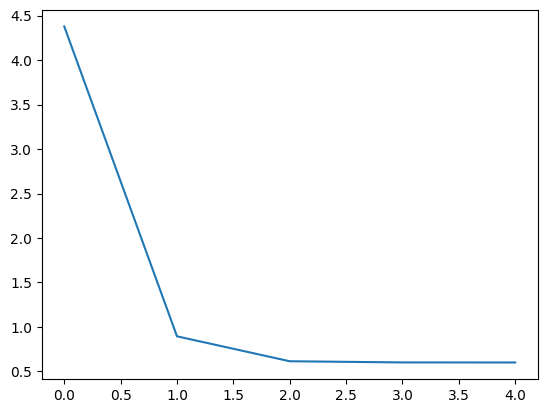

In [40]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)

In [42]:
print(r_losses[-1])

0.6012495519878628


[1.032324  2.9950016 0.9896828 6.9872613 5.0578628 2.4095361 1.8101711
 1.444435  1.2020389 1.0736494]
[1. 3. 1. 7. 5. 2. 3. 1. 2. 0.]


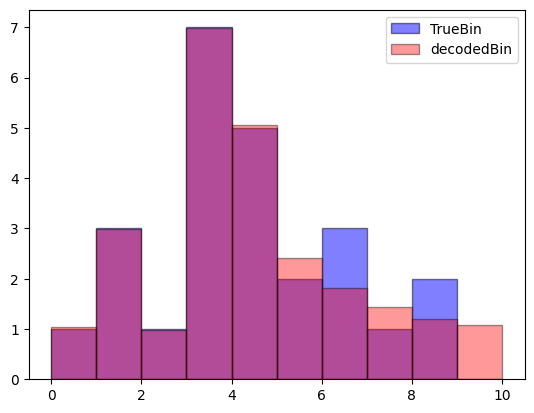

In [43]:
testP,_ = generateTrainingData(1,1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [8]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)


In [9]:
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-3)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         1,740
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         1,740
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         1,740
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         1,740
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        1,740
│    │    └─Rever

In [59]:
batch_size = 512
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 100 == 0):
      print(f"nll:{cnf_loss}")

    cnf_loss.backward()
    flowOptim.step()





  0%|          | 0/5 [00:00<?, ?it/s]

nll:9.897768020629883
nll:6.1397905349731445
nll:4.952418804168701
nll:4.1308183670043945
nll:3.1998069286346436
nll:2.2863059043884277
nll:1.9057916402816772
nll:1.5829646587371826
nll:1.2236179113388062
nll:1.0401527881622314
nll:0.6692891120910645
nll:0.6453036665916443
nll:0.5555078387260437
nll:0.49367815256118774
nll:0.43540796637535095
nll:0.45887643098831177
nll:0.26902642846107483
nll:0.041689157485961914
nll:0.2180221676826477
nll:0.06837049871683121
nll:0.13439898192882538
nll:0.09292243421077728
nll:0.13595208525657654
nll:-0.07813963294029236
nll:-0.05399457365274429
nll:-0.07000737637281418
nll:-0.10167311877012253
nll:0.06339879333972931
nll:-0.08105958253145218
nll:-0.1054123193025589
nll:-0.08622489869594574
nll:-0.2070026993751526
nll:-0.20760339498519897
nll:-0.24287138879299164
nll:-0.23079729080200195
nll:-0.24640591442584991
nll:-0.2700667381286621
nll:-0.2452586144208908
nll:-0.23144470155239105
nll:-0.2556689381599426
nll:-0.216651052236557
nll:-0.37455344200134

 20%|██        | 1/5 [09:34<38:17, 574.26s/it]

nll:-1.0895406007766724
nll:-0.9954745769500732
nll:-1.1132254600524902
nll:-1.0618280172348022
nll:-1.166683554649353
nll:-1.050426721572876
nll:-1.1190356016159058
nll:-1.1509816646575928
nll:-0.9878655672073364
nll:-1.1154735088348389
nll:-1.096937894821167
nll:-1.200507640838623
nll:-1.188593864440918
nll:-1.2592236995697021
nll:-1.1515469551086426
nll:-1.1182692050933838
nll:-1.0014848709106445
nll:-1.1487314701080322
nll:-1.0438706874847412
nll:-1.1341620683670044
nll:-1.2025209665298462
nll:-1.1656471490859985
nll:-1.1042943000793457
nll:-1.1962289810180664
nll:-1.135745882987976
nll:-1.0527987480163574
nll:-1.114694595336914
nll:-1.1101995706558228
nll:-1.1497118473052979
nll:-1.132433295249939
nll:-1.1595333814620972
nll:-1.0628741979599
nll:-1.1195638179779053
nll:-1.1214916706085205
nll:-1.108283281326294
nll:-1.173426628112793
nll:-1.0831271409988403
nll:-1.1185684204101562
nll:-1.1273871660232544
nll:-1.1263659000396729
nll:-1.210728406906128
nll:-1.080293893814087
nll:-1.

 40%|████      | 2/5 [19:07<28:40, 573.41s/it]

nll:-1.1674113273620605
nll:-1.1960651874542236
nll:-1.069153070449829
nll:-1.1813080310821533
nll:-1.1675854921340942
nll:-1.2737336158752441
nll:-1.1525328159332275
nll:-1.2634224891662598
nll:-1.2196571826934814
nll:-1.2502285242080688
nll:-1.2093539237976074
nll:-1.3019156455993652
nll:-0.890457808971405
nll:-1.121330738067627
nll:-1.1656676530838013
nll:-1.1581130027770996
nll:-1.3351225852966309
nll:-1.2169852256774902
nll:-1.2965142726898193
nll:-1.180963397026062
nll:-1.2099663019180298
nll:-1.1752780675888062
nll:-1.1539653539657593
nll:-1.221668004989624
nll:-1.262704610824585
nll:-1.1474053859710693
nll:-1.1530601978302002
nll:-1.2530994415283203
nll:-1.1238868236541748
nll:-1.1105918884277344
nll:-1.1400498151779175
nll:-1.2908072471618652
nll:-1.3001034259796143
nll:-1.2752671241760254
nll:-1.0679395198822021
nll:-1.1119365692138672
nll:-1.232957363128662
nll:-1.2314848899841309
nll:-1.1114310026168823
nll:-1.1587101221084595
nll:-1.1676788330078125
nll:-1.3127939701080322

 60%|██████    | 3/5 [28:39<19:06, 573.06s/it]

nll:-1.086883306503296
nll:-1.053771734237671
nll:-1.0241780281066895
nll:-1.0540506839752197
nll:-1.0315749645233154
nll:-0.9454899430274963
nll:-1.1653980016708374
nll:-1.0153205394744873
nll:-0.9981998205184937
nll:-1.064549207687378
nll:-1.0900253057479858
nll:-1.0815941095352173
nll:-1.1697351932525635
nll:-1.0908222198486328
nll:-1.1144812107086182
nll:-1.1399043798446655
nll:-1.2036068439483643
nll:-1.18206787109375
nll:-1.0780174732208252
nll:-1.1096986532211304
nll:-1.148315191268921
nll:-1.079850673675537
nll:-1.1162433624267578
nll:-1.1952608823776245
nll:-1.0083198547363281
nll:-1.2685449123382568
nll:-1.1442608833312988
nll:-1.1717147827148438
nll:-1.1604398488998413
nll:-1.2096457481384277
nll:-1.1825711727142334
nll:-1.237669825553894
nll:-1.2034051418304443
nll:-1.1331281661987305
nll:-1.1113722324371338
nll:-1.1742794513702393
nll:-1.1218898296356201
nll:-1.1687636375427246
nll:-1.2322673797607422
nll:-1.202223777770996
nll:-1.113037109375
nll:-1.1415319442749023
nll:-

 80%|████████  | 4/5 [38:24<09:37, 577.51s/it]

nll:-1.2447956800460815
nll:-1.1279423236846924
nll:-1.2603833675384521
nll:-1.225825309753418
nll:-1.32387113571167
nll:-1.332977294921875
nll:-1.3264150619506836
nll:-1.3983898162841797
nll:-1.3214565515518188
nll:-1.3000767230987549
nll:-1.320491909980774
nll:-1.2490057945251465
nll:-1.3961832523345947
nll:-1.3960644006729126
nll:-1.3168525695800781
nll:-1.1649301052093506
nll:-1.2629194259643555
nll:-1.4746143817901611
nll:-1.2354518175125122
nll:-1.3691177368164062
nll:-1.3798964023590088
nll:-1.389730453491211
nll:-1.2564778327941895
nll:-1.4137229919433594
nll:-1.3238945007324219
nll:-1.3972184658050537
nll:-1.4242126941680908
nll:-1.4281235933303833
nll:-1.4429256916046143
nll:-1.3114246129989624
nll:-1.2262861728668213
nll:-1.1687796115875244
nll:-1.225907564163208
nll:-1.3571956157684326
nll:1.7844433784484863
nll:-0.7672856450080872
nll:-1.0216996669769287
nll:-1.0040850639343262
nll:-1.150637149810791
nll:-1.113410234451294
nll:-1.128969669342041
nll:-1.2162590026855469
nll

100%|██████████| 5/5 [47:54<00:00, 574.98s/it]


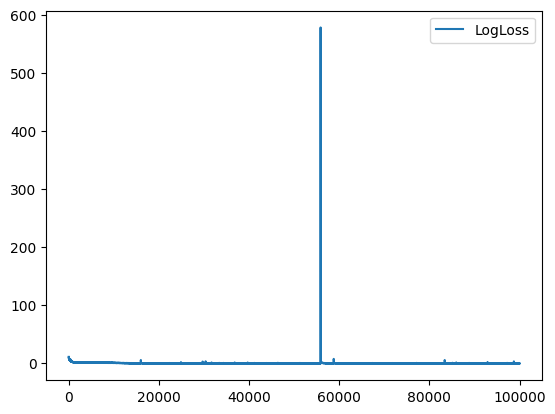

-1.3492629528045654


In [60]:
plt.plot(logLoss,label="LogLoss")
plt.legend()
plt.show()

print(logLoss[-1])

In [ ]:
torch.save({
    "cnf": CNFModel.state_dict(),
    "optimizer": flowOptim.state_dict(),
}, "CNF_params_Optim.pth")

torch.save({
    "ae": encodeModel.state_dict(),\
    "AE_Optim": reconOptim.state_dict(),
}, "AE_params_Optim.pth")


In [10]:
ckpt_AE  = torch.load("AE_params_Optim.pth", map_location=device)
ckpt_CNF = torch.load("CNF_params_Optim.pth", map_location=device)
encodeModel.load_state_dict(ckpt_AE["ae"])
CNFModel.load_state_dict(ckpt_CNF["cnf"])

encodeModel.eval()
CNFModel.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=16, bias=True)
          (context_layer): Linear(in_features=6, out_features=16, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (context_layer): Linear(in_features=6, out_features=16, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=16, out_features=16, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=16, out_features=12, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=16, bias=True)
   

In [11]:
def peak_finder(samples, num, bins=100):
    data = samples[:, num]

    hist, edges = np.histogram(data, bins=bins)

    centers = 0.5 * (edges[:-1] + edges[1:])
    mask = (centers > 0) & (centers < 100)
    idx = np.argmax(hist[mask])
    return centers[mask][idx].item()

In [29]:
cnfP, cnfT = generateTrainingData(1,100000)
cnfT = cnfT[0]
print(cnfP.nbytes)

cnfP_tensor = torch.tensor(cnfP,dtype = torch.float32)

batch_test = DataLoader(cnfP_tensor, batch_size = 4096)

8000000


In [30]:
testData = []

with torch.no_grad():
  for x_batch in batch_test:
    x = x_batch.to(device)
    cnfP_en = encodeModel.encode(x)
    samples = CNFModel.sample(1000,context=cnfP_en).cpu().numpy()
    sample_cut = samples.reshape(-1,samples.shape[-1])
    testData.append(sample_cut)


In [34]:
testnp = np.concatenate(testData,axis=0)
print(testnp.shape)

(100000000, 6)


In [36]:
print(testnp)

[[19.775803   1.7664385  1.872991  20.627148   7.2558107  6.7010803]
 [25.006706   2.285683   2.503504  18.722221   5.864645   7.24935  ]
 [32.46358    2.3117378  1.876022  16.692818   6.2996135  5.9050813]
 ...
 [13.382854   1.9503299  2.6997225 27.381636   7.164574   7.866778 ]
 [23.703974   1.856915   2.5868466 26.605831   7.151454   6.307488 ]
 [37.533733   1.7821672  2.8352678 23.603533   5.775695   9.639243 ]]


(array([1.4759000e+04, 1.2896360e+06, 8.8189700e+06, 1.8094405e+07,
        2.2775002e+07, 2.1390008e+07, 1.5978680e+07, 9.3191590e+06,
        2.1887660e+06, 1.1691000e+05]),
 array([2.90954206e-03, 6.00255299e+00, 1.20021963e+01, 1.80018387e+01,
        2.40014820e+01, 3.00011253e+01, 3.60007706e+01, 4.20004158e+01,
        4.80000572e+01, 5.39996986e+01, 5.99993439e+01]),
 <BarContainer object of 10 artists>)

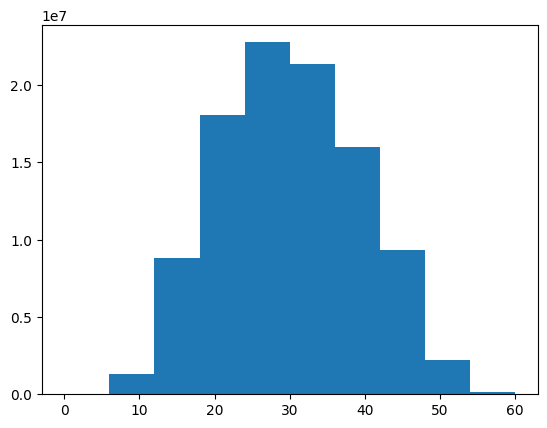

In [39]:
N1_cnf = testnp[:,0]
N1s = N1_cnf[(N1_cnf > 0) & (N1_cnf < 60)]
plt.hist(N1s)

In [41]:
print(cnfT)

[35.59108119  2.06567103  2.90196538 19.83804999  8.6859983   7.38883527]
